In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import plot_importance
from lightgbm import plot_importance as plot_important_lgbm
from xgboost import cv
import lightgbm as lgb
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from bayes_opt import BayesianOptimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/saved-data/preprocess_train.csv')
test = pd.read_csv('/kaggle/input/saved-data/preprocess_test.csv')
test_ID = pd.read_csv('/kaggle/input/umojahack-2023-africa-carbon-dioxide/Test(3).csv')
test_ID = test_ID['ID_LAT_LON_YEAR_WEEK']

In [4]:
X = train.drop(['emission','ID_LAT_LON_YEAR_WEEK','Place','date'],axis=1)
y = train.emission
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Xgboost Validation**

# **Simple validation**

In [7]:
params = {'eta': 0.19,
 'eval_metric': 'rmse',
 'gamma': 5.420256552806366,
 'n_estimators': 970,
 'subsample': 0.78}
xgb_model = XGBRegressor(**params,tree_method='gpu_hist')

In [ ]:
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=400, early_stopping_rounds=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

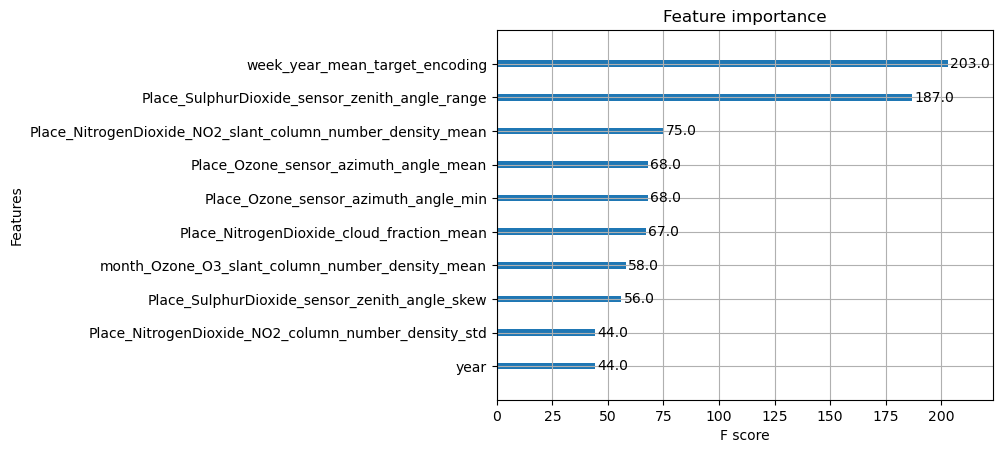

In [34]:
plot_importance(xgb_model,max_num_features=10)

In [12]:
xgb_model.predict(test)

array([ 2936.1663,  7244.94  ,  7371.1484, ..., 28492.191 , 28118.906 ,
       27339.037 ], dtype=float32)

In [25]:
sub = pd.DataFrame()
sub['ID_LAT_LON_YEAR_WEEK'] = test_ID
sub['emission'] = xgb_model.predict(test)
sub

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2936.166260
1,ID_-23.53_27.47_2019_2,7244.939941
2,ID_-23.53_27.47_2019_3,7371.148438
3,ID_-23.53_27.47_2019_4,7385.651855
4,ID_-23.53_27.47_2019_5,3067.221924
...,...,...
28080,ID_-34.03_18.87_2022_45,28005.990234
28081,ID_-34.03_18.87_2022_46,28440.056641
28082,ID_-34.03_18.87_2022_47,28492.191406
28083,ID_-34.03_18.87_2022_48,28118.906250


In [26]:
sub.to_csv('kdjfaois.csv',index=False)

# **KFold Validation**

In [37]:
from sklearn.model_selection import KFold
# kf = KFold(n_splits=10)

In [12]:
cs_scor = cross_val_score(xgb_model,X, y, cv=5,scoring='neg_mean_squared_error')

In [18]:
rmse = np.sqrt(-cs_scor)
rmse

array([  9479.13469254, 112982.86560022,  11504.90663924,   7781.77276519,
        10493.05206819])

# **OOF Validation**

In [5]:
oof_scores = []
oof_predict = []
preds = pd.Series(0,index=test.index)

In [6]:
e = 1
for train_index, test_index in KFold(n_splits=10).split(X.values, y.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    print(f'fitting:{e}...')
    e+=1
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=400, early_stopping_rounds=10)
    
    # prinitng ascore
    oof_scores.append(mean_squared_error(y_test, xgb_model.predict(X_test),squared=False))
    print(f'RMSE of Round {e}:',oof_scores[-1])
    print('Done..')
    oof_predict.append(xgb_model.predict(test))

fitting:1...
[0]	validation_0-rmse:45722.31396	validation_1-rmse:2551.24272
[10]	validation_0-rmse:6769.97533	validation_1-rmse:7369.09774
RMSE of Round 2: 2244.0478646750266
Done..
fitting:2...
[0]	validation_0-rmse:45720.62655	validation_1-rmse:1793.80248
[12]	validation_0-rmse:4945.70629	validation_1-rmse:2048.85162
RMSE of Round 3: 1671.023901411288
Done..
fitting:3...
[0]	validation_0-rmse:13660.98913	validation_1-rmse:159684.90807
[22]	validation_0-rmse:894.09641	validation_1-rmse:158380.91391
RMSE of Round 4: 158336.93799238486
Done..
fitting:4...
[0]	validation_0-rmse:43878.21821	validation_1-rmse:53831.17389
[9]	validation_0-rmse:7334.90168	validation_1-rmse:137956.27926
RMSE of Round 5: 53831.173544521786
Done..
fitting:5...
[0]	validation_0-rmse:45719.26115	validation_1-rmse:2764.42176
[11]	validation_0-rmse:5920.41806	validation_1-rmse:3541.16887
RMSE of Round 6: 2718.018685612567
Done..
fitting:6...
[0]	validation_0-rmse:45725.38912	validation_1-rmse:1445.38976
[9]	validat

In [8]:
np.mean(oof_predict)

6753.618

## ***Get Average of OOF***

In [23]:
for n in range(10):
    preds+=oof_predict[n]*0.1

In [10]:
test_ID = pd.read_csv('/kaggle/input/umojahack-2023-africa-carbon-dioxide/Test(3).csv')
test_ID = test_ID['ID_LAT_LON_YEAR_WEEK']

In [33]:
sub = pd.DataFrame()
sub['ID_LAT_LON_YEAR_WEEK'] = test_ID
sub['emission'] = oof_predict[5]
sub

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2645.759521
1,ID_-23.53_27.47_2019_2,2645.759521
2,ID_-23.53_27.47_2019_3,2645.759521
3,ID_-23.53_27.47_2019_4,2645.759521
4,ID_-23.53_27.47_2019_5,2645.759521
...,...,...
28080,ID_-34.03_18.87_2022_45,8137.042969
28081,ID_-34.03_18.87_2022_46,8137.042969
28082,ID_-34.03_18.87_2022_47,8137.042969
28083,ID_-34.03_18.87_2022_48,8137.042969


In [34]:
sub.to_csv('dafs.csv',index=False)

In [35]:
for i in range(10):
    sub['emission'] = oof_predict[i]
    sub.to_csv(f'kfold10sub{i}.csv',index=False)

# **5 Kfold**

In [36]:
oof_scores = []
oof_predict = []
preds = pd.Series(0,index=test.index)
e = 1

for train_index, test_index in KFold(n_splits=5).split(X.values, y.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    print(f'fitting:{e}...')
    e+=1
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=400, early_stopping_rounds=100)
    
    # prinitng ascore
    oof_scores.append(mean_squared_error(y_test, xgb_model.predict(X_test),squared=False))
    print(f'RMSE of Round {e}:',oof_scores[-1])
    print('Done..')
    oof_predict.append(xgb_model.predict(test))

print('mean rmse:',np.mean(oof_predict))

fitting:1...
[0]	validation_0-rmse:48516.11287	validation_1-rmse:2256.27169
[10]	validation_0-rmse:7287.55705	validation_1-rmse:8008.73259
RMSE of Round 2: 2256.271711789796
Done..
fitting:2...
[0]	validation_0-rmse:6068.68918	validation_1-rmse:116986.66628
[41]	validation_0-rmse:270.25807	validation_1-rmse:112997.26575
RMSE of Round 3: 112993.29264255277
Done..
fitting:3...
[0]	validation_0-rmse:48493.65985	validation_1-rmse:2884.18908
[10]	validation_0-rmse:7444.85704	validation_1-rmse:9479.63066
RMSE of Round 4: 2884.1890910517395
Done..
fitting:4...
[0]	validation_0-rmse:48301.45895	validation_1-rmse:9538.11533
[36]	validation_0-rmse:923.77983	validation_1-rmse:7750.88868
RMSE of Round 5: 7724.594719905353
Done..
fitting:5...
[0]	validation_0-rmse:48312.40778	validation_1-rmse:8854.39742
[17]	validation_0-rmse:2745.04074	validation_1-rmse:8284.31680
RMSE of Round 6: 6243.119763180648
Done..
mean rmse: 7925.336


In [37]:
for i in range(5):
    sub['emission'] = oof_predict[i]
    sub.to_csv(f'kfold5sub{i}.csv',index=False)

# **XGBoost Full Train**

In [5]:
xgb_model.fit(X,y,verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.19,
             eval_metric='rmse', gamma=5.420256552806366, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.189999998, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=970, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [9]:
xgb_model.predict(test)

(-8284.561, 119322.125)

In [11]:
sub = pd.DataFrame()
sub['ID_LAT_LON_YEAR_WEEK'] = test_ID
sub['emission'] = xgb_model.predict(test)
sub

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,2025.807861
1,ID_-23.53_27.47_2019_2,7060.941406
2,ID_-23.53_27.47_2019_3,7149.402344
3,ID_-23.53_27.47_2019_4,7203.728027
4,ID_-23.53_27.47_2019_5,4384.478027
...,...,...
28080,ID_-34.03_18.87_2022_45,27331.349609
28081,ID_-34.03_18.87_2022_46,26843.892578
28082,ID_-34.03_18.87_2022_47,27326.031250
28083,ID_-34.03_18.87_2022_48,26870.666016


In [12]:
sub.to_csv('fdaskfjkasdf.csv',index=False)

In [28]:
# np.expm1(np.log1p(y))

# scaled target

In [29]:
xgb_model.fit(X,np.log1p(y),verbose=100)
sub['emission'] = np.expm1(xgb_model.predict(test))
sub.to_csv('dfkajsf.csv',index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

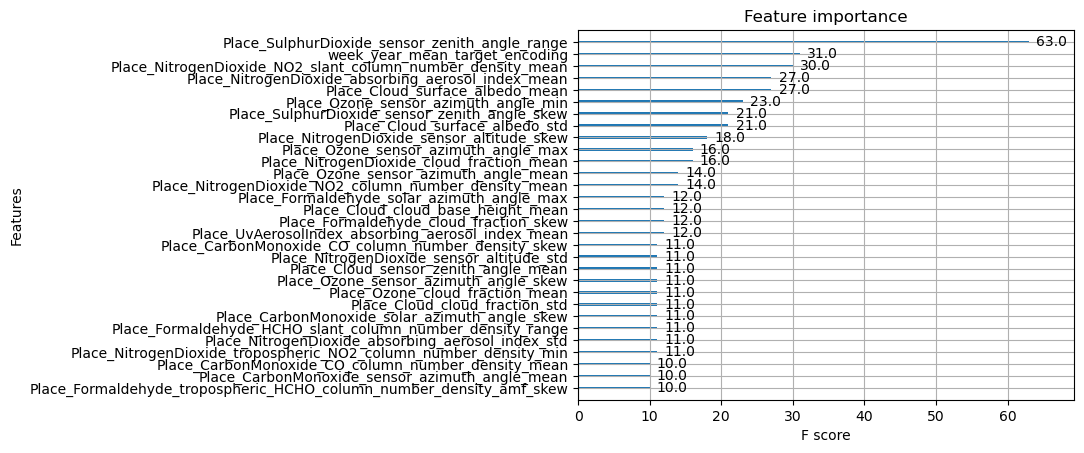

In [30]:
plot_importance(xgb_model,max_num_features=30)

# **LightGBM**

In [6]:
lgbm_param = {'bagging_fraction': 0.6214882520102827,
 'eval_metric': 'rmse',
 'learning_rate': 0.14,
 'max_depth': 11,
 'n_estimators': 890,
 'subsample': 0.89}

In [6]:
lgbm=LGBMRegressor(**lgbm_param,device="gpu")

In [7]:
lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=400, early_stopping_rounds=10)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.6214882520102827, subsample=0.89 will be ignored. Current value: bagging_fraction=0.6214882520102827


LGBMRegressor(bagging_fraction=0.6214882520102827, device='gpu',
              eval_metric='rmse', learning_rate=0.14, max_depth=11,
              n_estimators=890, subsample=0.89)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

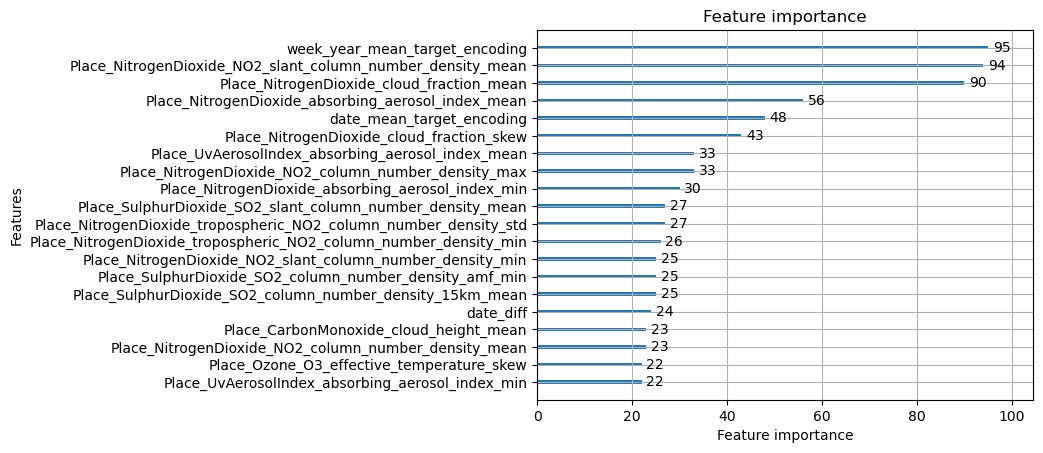

In [9]:
plot_important_lgbm(lgbm,max_num_features=20)

In [14]:
sub = pd.DataFrame()
sub['ID_LAT_LON_YEAR_WEEK'] = test_ID
sub['emission'] = lgbm.predict(test)
sub.to_csv('lgbmadjfi.csv',index=False)

# **CV**

In [5]:
lgbm=LGBMRegressor(**lgbm_param,device="gpu")
oof_scores = []
oof_predict = []
preds = pd.Series(0,index=test.index)
e = 1

for train_index, test_index in KFold(n_splits=3).split(X.values, y.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    print(f'fitting:{e}...')
    e+=1
    lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=100)
    
    # prinitng ascore
    oof_scores.append(mean_squared_error(y_test, lgbm.predict(X_test),squared=False))
    print(f'RMSE of Round {e}:',oof_scores[-1])
    print('Done..')
    oof_predict.append(lgbm.predict(test))

print('mean rmse:',np.mean(oof_predict))

NameError: name 'lgbm_param' is not defined

# **LGMP + XGBoost**

In [8]:
xgb_model.fit(X,np.log1p(y),verbose=100)
xgb_pred = np.expm1(xgb_model.predict(test))

In [9]:
lgbm=LGBMRegressor(**lgbm_param,device="gpu")
lgbm.fit(X,np.log1p(y),verbose=100)
lgbm_pred = np.expm1(lgbm.predict(test))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.6214882520102827, subsample=0.89 will be ignored. Current value: bagging_fraction=0.6214882520102827


In [10]:
# Full pred 
preds = xgb_pred*0.5 + lgbm_pred*0.5
sub = pd.DataFrame()
sub['ID_LAT_LON_YEAR_WEEK'] = test_ID
sub['emission'] = preds
sub.to_csv('boostdksfasdl.csv',index=False)